# ROCK-PAPER-SCISSORS: Multi-class Classification
## Comparing ALL Techniques: MLP → Augmentation → HOG → CNN → Transfer Learning

**Goal:** Maximize validation accuracy - no more constraints!

**Models Compared:**
1. Decision Tree (baseline)
2. Logistic Regression (baseline)
3. **MLP** - Feed-Forward Neural Network
4. **MLP + Data Augmentation** - More training data
5. **MLP + HOG Features** - Better features
6. **CNN** - Spatial learning
7. **Transfer Learning** - Pre-trained features

## 1. Setup and Imports

In [1]:
import sys
!{sys.executable} -m pip install -U scikit-learn

In [2]:
import sys
!{sys.executable} -m pip install -U scikit-image

In [3]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os

# Import from src/ modules (no more local function definitions!)
from src.data import load_images_as_numpy
from src.models import build_mlp_model, build_cnn_model, build_transfer_model
from src.features import augment_dataset, extract_hog_features, apply_standard_scaler
from src.train import compile_model, get_callbacks
from src.eval import evaluate_model, plot_history

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.20.0
Keras version: 3.13.2


In [4]:
DATA_ROOT = "../data/rps"
IMG_H, IMG_W = 224, 224
BATCH_SIZE = 16
EPOCHS = 90
CLASSES = ['paper', 'rock', 'scissor']
NUM_CLASSES = len(CLASSES)

print(f"Data root: {DATA_ROOT}")
print(f"Image size: {IMG_H}x{IMG_W}")
print(f"Classes: {CLASSES}")

Data root: ../data/rps
Image size: 224x224
Classes: ['paper', 'rock', 'scissor']


## 2. Load Data as NumPy Arrays

In [5]:
print("Loading training data...")
X_train, y_train, class_names = load_images_as_numpy(
    os.path.join(DATA_ROOT, 'train')
)

print("\nLoading validation data...")
X_val, y_val, _ = load_images_as_numpy(
    os.path.join(DATA_ROOT, 'val'),
    verbose=False
)

print("\nLoading test data...")
X_test, y_test, _ = load_images_as_numpy(
    os.path.join(DATA_ROOT, 'test'),
    verbose=False
)

print("\n" + "="*60)
print("DATA LOADED SUCCESSFULLY")
print("="*60)
print(f"Train set: {X_train.shape[0]} images, shape {X_train.shape[1:]}")
print(f"Validation set: {X_val.shape[0]} images, shape {X_val.shape[1:]}")
print(f"Test set: {X_test.shape[0]} images, shape {X_test.shape[1:]}")

print("\nClass distribution in training:")
for i, class_name in enumerate(CLASSES):
    count = np.sum(y_train == i)
    print(f"  {class_name}: {count} images ({count/len(y_train)*100:.1f}%)")

Loading training data...
Loading paper... 266 images
Loading rock... 267 images
Loading scissor... 265 images

Loading validation data...

Loading test data...

DATA LOADED SUCCESSFULLY
Train set: 798 images, shape (224, 224, 3)
Validation set: 199 images, shape (224, 224, 3)
Test set: 25 images, shape (224, 224, 3)

Class distribution in training:
  paper: 266 images (33.3%)
  rock: 267 images (33.5%)
  scissor: 265 images (33.2%)


## 3. Visualize Sample Images

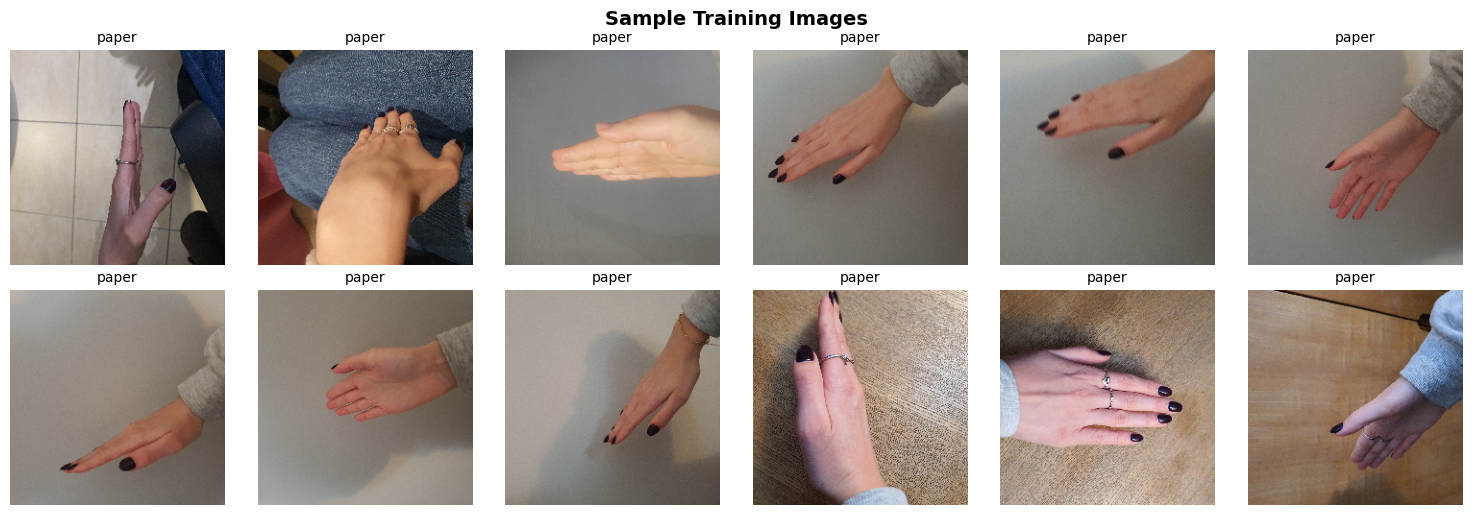

In [6]:
plt.figure(figsize=(15, 5))
for i in range(min(12, len(X_train))):
    plt.subplot(2, 6, i + 1)
    plt.imshow(X_train[i])
    plt.title(CLASSES[y_train[i]], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Sample Training Images', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 4. Prepare Data for MLP (Flatten)

In [7]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Original shape: {X_train.shape}")
print(f"Flattened shape: {X_train_flat.shape}")
print(f"Each image is now a vector of {X_train_flat.shape[1]:,} features")

Original shape: (798, 224, 224, 3)
Flattened shape: (798, 150528)
Each image is now a vector of 150,528 features


In [8]:
# Apply StandardScaler for better MLP performance
print("Applying StandardScaler (zero mean, unit variance)...")
X_train_scaled, X_val_scaled, X_test_scaled, scaler = apply_standard_scaler(
    X_train_flat, X_val_flat, X_test_flat
)

print(f"\nBefore scaling:")
print(f"  Mean: {X_train_flat.mean():.4f}, Std: {X_train_flat.std():.4f}")
print(f"After scaling:")
print(f"  Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print("StandardScaler improves MLP convergence by normalizing features!")

Applying StandardScaler (zero mean, unit variance)...

Before scaling:
  Mean: 0.4938, Std: 0.2346
After scaling:
  Mean: 0.0000, Std: 1.0000
StandardScaler improves MLP convergence by normalizing features!


## 5. Classical ML Baselines

In [9]:
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=15, random_state=42)
dt_model.fit(X_train_flat, y_train)
y_val_pred_dt = dt_model.predict(X_val_flat)
dt_acc = accuracy_score(y_val, y_val_pred_dt)
print(f"Decision Tree Validation Accuracy: {dt_acc:.2%}")

Training Decision Tree...
Decision Tree Validation Accuracy: 46.73%


In [10]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, C=0.1)
lr_model.fit(X_train_flat, y_train)
y_val_pred_lr = lr_model.predict(X_val_flat)
lr_acc = accuracy_score(y_val, y_val_pred_lr)
print(f"Logistic Regression Validation Accuracy: {lr_acc:.2%}")

Training Logistic Regression...
Logistic Regression Validation Accuracy: 61.81%


## 6. Baseline MLP Model (with StandardScaler)

In [11]:
mlp_model = build_mlp_model(X_train_scaled.shape[1], NUM_CLASSES)
mlp_model.summary()

Model: "MLP_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │      77,070,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,239,043 (294.64 MB)

 Trainable params: 77,237,251 (294.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

TRAINING BASELINE MLP (with StandardScaler)
Epoch 1/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 532ms/step - accuracy: 0.3659 - loss: 1.2991 - val_accuracy: 0.3719 - val_loss: 1.4518 - learning_rate: 0.0010
Epoch 2/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 509ms/step - accuracy: 0.4862 - loss: 1.1144 - val_accuracy: 0.3719 - val_loss: 1.3643 - learning_rate: 0.0010
Epoch 3/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 513ms/step - accuracy: 0.4724 - loss: 1.0744 - val_accuracy: 0.3819 - val_loss: 1.3155 - learning_rate: 0.0010
Epoch 4/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.5201 - loss: 1.0092 - val_accuracy: 0.4171 - val_loss: 1.2167 - learning_rate: 0.0010
Epoch 5/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 527ms/step - accuracy: 0.5990 - loss: 0.9328 - val_accuracy: 0.4673 - val_loss: 1.1918 - learning_rate: 0.0010
Epoch 6/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.6065 - loss: 0.8950 - val_accuracy: 0.5025 - val_loss: 1.0809 - learning_rate: 0.0010
Epoch 7/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 

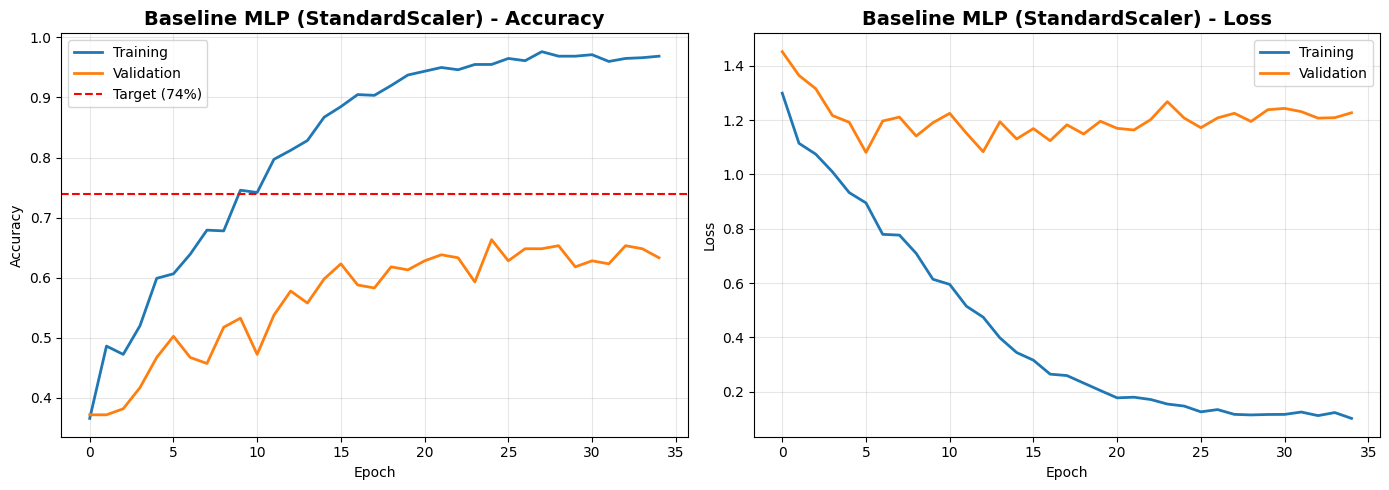

Best val accuracy: 66.33% at epoch 25


In [12]:
compile_model(mlp_model)
callbacks = get_callbacks()

print("="*70)
print("TRAINING BASELINE MLP (with StandardScaler)")
print("="*70)

history_mlp = mlp_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

mlp_val_loss, mlp_val_acc = mlp_model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\nBaseline MLP Validation Accuracy: {mlp_val_acc:.2%}")
plot_history(history_mlp, title="Baseline MLP (StandardScaler)")

## 7. MLP + Data Augmentation (with StandardScaler)

In [13]:
print("Augmenting training data...")
X_train_aug, y_train_aug = augment_dataset(X_train, y_train, augment_factor=2)
print(f"Original training size: {len(X_train)}")
print(f"Augmented training size: {len(X_train_aug)}")

X_train_aug_flat = X_train_aug.reshape(X_train_aug.shape[0], -1)

# Apply StandardScaler to augmented data
print("\nApplying StandardScaler to augmented data...")
X_train_aug_scaled, X_val_aug_scaled, X_test_aug_scaled, scaler_aug = apply_standard_scaler(
    X_train_aug_flat, X_val_flat, X_test_flat
)

Augmenting training data...
Original training size: 798
Augmented training size: 2394

Applying StandardScaler to augmented data...


In [ ]:
mlp_aug_model = build_mlp_model(X_train_aug_scaled.shape[1], NUM_CLASSES)
compile_model(mlp_aug_model)
callbacks_aug = get_callbacks()

print("="*70)
print("TRAINING MLP + DATA AUGMENTATION (with StandardScaler)")
print("="*70)

history_mlp_aug = mlp_aug_model.fit(
    X_train_aug_scaled, y_train_aug,
    validation_data=(X_val_aug_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_aug,
    verbose=1
)

_, mlp_aug_val_acc = mlp_aug_model.evaluate(X_val_aug_scaled, y_val, verbose=0)
print(f"\nMLP + Augmentation Validation Accuracy: {mlp_aug_val_acc:.2%}")
plot_history(history_mlp_aug, title="MLP + Augmentation + StandardScaler")

TRAINING MLP + DATA AUGMENTATION (with StandardScaler)
Epoch 1/90
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 493ms/step - accuracy: 0.3258 - loss: 1.2543 - val_accuracy: 0.3065 - val_loss: 1.1233 - learning_rate: 0.0010
Epoch 2/90
 48/150 ━━━━━━━━━━━━━━━━━━━━ 49s 480ms/step - accuracy: 0.3678 - loss: 1.1520

## 8. MLP + HOG Features (with StandardScaler)

In [ ]:
print("Extracting HOG features...")
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)
X_test_hog = extract_hog_features(X_test)

print(f"Original features: {X_train_flat.shape[1]:,}")
print(f"HOG features: {X_train_hog.shape[1]:,}")

# Apply StandardScaler to HOG features
print("\nApplying StandardScaler to HOG features...")
X_train_hog_scaled, X_val_hog_scaled, X_test_hog_scaled, scaler_hog = apply_standard_scaler(
    X_train_hog, X_val_hog, X_test_hog
)

In [ ]:
mlp_hog_model = build_mlp_model(X_train_hog_scaled.shape[1], NUM_CLASSES)
compile_model(mlp_hog_model)
callbacks_hog = get_callbacks()

print("="*70)
print("TRAINING MLP + HOG FEATURES (with StandardScaler)")
print("="*70)

history_mlp_hog = mlp_hog_model.fit(
    X_train_hog_scaled, y_train,
    validation_data=(X_val_hog_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_hog,
    verbose=1
)

_, mlp_hog_val_acc = mlp_hog_model.evaluate(X_val_hog_scaled, y_val, verbose=0)
print(f"\nMLP + HOG Validation Accuracy: {mlp_hog_val_acc:.2%}")
plot_history(history_mlp_hog, title="MLP + HOG + StandardScaler")

## 9. CNN Model

In [ ]:
cnn_model = build_cnn_model((IMG_H, IMG_W, 3), NUM_CLASSES)
cnn_model.summary()

In [ ]:
compile_model(cnn_model)
callbacks_cnn = get_callbacks()

print("="*70)
print("TRAINING CNN")
print("="*70)

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_cnn,
    verbose=1
)

_, cnn_val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)
print(f"\nCNN Validation Accuracy: {cnn_val_acc:.2%}")
plot_history(history_cnn, title="CNN")

## 10. Transfer Learning (MobileNetV2)

In [ ]:
transfer_model = build_transfer_model(NUM_CLASSES, input_shape=(IMG_H, IMG_W, 3))
transfer_model.summary()

In [ ]:
compile_model(transfer_model, learning_rate=0.0001)
callbacks_transfer = get_callbacks(patience=15)

print("="*70)
print("TRAINING TRANSFER LEARNING (MobileNetV2)")
print("="*70)

history_transfer = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_transfer,
    verbose=1
)

_, transfer_val_acc = transfer_model.evaluate(X_val, y_val, verbose=0)
print(f"\nTransfer Learning Validation Accuracy: {transfer_val_acc:.2%}")
plot_history(history_transfer, title="Transfer Learning (MobileNetV2)")

## 11. Final Comparison

In [ ]:
# =========================
# FINAL MODEL COMPARISON
# =========================

# Adjust if your label order/names differ
class_names = ["rock", "paper", "scissors"]

rows = []

def add_row(name, model, Xv, yv, Xt, yt, val_acc):
    # Silence reports/plots so the cell doesn't spam output
    s = evaluate_model(
        model,
        Xv, yv,
        Xt, yt,
        class_names,
        show_plots=False,
        print_reports=False
    )
    rows.append({
        "Model": name,
        "Validation Accuracy (%)": val_acc * 100,
        "Val F1 Macro (%)": s["val"]["f1_macro"] * 100,
        "Test F1 Macro (%)": s["test"]["f1_macro"] * 100,
    })

add_row("Decision Tree", dt_model, X_val_scaled, y_val, X_test_scaled, y_test, dt_acc)
add_row("Logistic Regression", lr_model, X_val_scaled, y_val, X_test_scaled, y_test, lr_acc)
add_row("MLP (Baseline)", mlp_model, X_val_scaled, y_val, X_test_scaled, y_test, mlp_val_acc)
add_row("MLP + Augmentation", mlp_aug_model, X_val_aug_scaled, y_val, X_test_aug_scaled, y_test, mlp_aug_val_acc)
add_row("MLP + HOG", mlp_hog_model, X_val_hog_scaled, y_val, X_test_hog_scaled, y_test, mlp_hog_val_acc)
add_row("CNN", cnn_model, X_val, y_val, X_test, y_test, cnn_val_acc)
add_row("Transfer Learning", transfer_model, X_val, y_val, X_test, y_test, transfer_val_acc)

# Build + sort
results = pd.DataFrame(rows).sort_values(
    "Val F1 Macro (%)", ascending=False, na_position="last"
).reset_index(drop=True)

print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)
print(results.to_string(index=False))
print("="*70)

# Plot Val F1 Macro (%)
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(results)))
bars = ax.barh(results["Model"], results["Val F1 Macro (%)"], color=colors)

ax.set_xlabel("Validation F1 Macro (%)", fontsize=12, fontweight="bold")
ax.set_title("Model Comparison - Validation Macro F1", fontsize=14, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
ax.set_xlim(0, 105)

for bar, val in zip(bars, results["Val F1 Macro (%)"]):
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f"{val:.1f}%",
        ha="left",
        va="center",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

results

## 12. Evaluate Best Model

In [ ]:
# 1️⃣ Sort results FIRST by validation macro F1
results = results.sort_values(
    "Val F1 Macro (%)",
    ascending=False,
    na_position="last"
).reset_index(drop=True)

# Select best model AFTER sorting
best_model_name = results.iloc[0]["Model"]
print(f"Best model: {best_model_name}")

# Map model name to model object and correct inputs
if best_model_name == "Transfer Learning":
    best_model = transfer_model
    X_val_input, X_test_input = X_val, X_test

elif best_model_name == "CNN":
    best_model = cnn_model
    X_val_input, X_test_input = X_val, X_test

elif best_model_name == "MLP + HOG":
    best_model = mlp_hog_model
    X_val_input, X_test_input = X_val_hog_scaled, X_test_hog_scaled

elif best_model_name == "MLP + Augmentation":
    best_model = mlp_aug_model
    X_val_input, X_test_input = X_val_aug_scaled, X_test_aug_scaled

else:  # MLP (Baseline)
    best_model = mlp_model
    X_val_input, X_test_input = X_val_scaled, X_test_scaled

# Evaluate best model (confusion matrices + per-class F1)
best_scores = evaluate_model(
    best_model,
    X_val_input, y_val,
    X_test_input, y_test,
    CLASSES
)

# Explicit macro F1 print (clear for graders)
print("\nBest model metrics:")
print(f"  Val F1 Macro (%):  {best_scores['val']['f1_macro'] * 100:.2f}")
print(f"  Test F1 Macro (%): {best_scores['test']['f1_macro'] * 100:.2f}")

## 13. Save Best Model

In [ ]:
best_model.save('rps_best_model.keras')
print(f"Best model ({best_model_name}) saved as: rps_best_model.keras")